In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline



#OR
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import sklearn.model_selection as ms
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split #split the thing 
from sklearn.model_selection import GridSearchCV 


from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgboost

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
######## Wells Fargo Competition Random Forest

from google.colab import files
uploaded = files.upload()
import io

train_data = pd.read_csv(io.BytesIO(uploaded['Simulated_Data_Train.csv']))
valid_data = pd.read_csv(io.BytesIO(uploaded['Simulated_Data_Validation.csv'])) #pick all three files at the same time
test_data = pd.read_csv(io.BytesIO(uploaded['Simulated_Data_Test.csv']))


Saving Simulated_Data_Train.csv to Simulated_Data_Train.csv
Saving Simulated_Data_Validation.csv to Simulated_Data_Validation.csv
Saving Simulated_Data_Test.csv to Simulated_Data_Test.csv


In [ ]:
print(train_data)
print(valid_data)
print(test_data)

       tot_credit_debt  avg_card_debt  ...  States  Default_ind
0             80826.71       15872.99  ...      AL          0.0
1             96052.60       12178.02  ...      FL          0.0
2             75212.76       12052.24  ...      AL          0.0
3             70727.84        8416.80  ...      SC          1.0
4             41604.47       10611.97  ...      LA          0.0
...                ...            ...  ...     ...          ...
19995        104765.01       13905.40  ...      GA          0.0
19996         83990.07       10325.02  ...      NC          0.0
19997        107606.69       17838.79  ...      SC          0.0
19998         78787.72       11447.61  ...      AL          0.0
19999         78296.90       10053.16  ...      AL          0.0

[20000 rows x 21 columns]
      tot_credit_debt  avg_card_debt  ...  States  Default_ind
0            63651.27        9019.99  ...      FL          1.0
1           105559.29       16692.19  ...      MS          0.0
2            960

In [ ]:
####Part 1: Clean Data

In [3]:
###Train Data
#This is similar to str() from R
for column in train_data:
    unique_vals = np.unique(train_data[column])
    nr_values = len(unique_vals)
    if nr_values < 12:
        print('The number of values for feature {} :{} -- {}'.format(column, nr_values,unique_vals))
    else:
        print('The number of values for feature {} :{}'.format(column, nr_values))

#Shows which predictors have missing values
train_data.isnull().sum() #Rep_income, uti_card_50plus_pct, 

#Shows the name of each columns
train_data.columns

#Find how many 99999 there are in avg_card_debt, and replacing the 99999 with NA
train_data.avg_card_debt == 99999
train_data[train_data['avg_card_debt'] == 99999] #There's 212 of 99999, this could skew the data

train_data['avg_card_debt'].replace(99999,np.nan,inplace=True)
train_data.replace(to_replace = 99999.0, value = np.nan)
train_data.avg_card_debt.max()
train_data['uti_card_50plus_pct'].replace("", np.nan,inplace=True)
train_data['rep_income'].replace("", np.nan, inplace=True)



#Fixing column name
train_data.columns = train_data.columns.str.replace(' ', '') #gets rid of all spaces in columns

#turning columns into factor
train_data['States'] = pd.Categorical(train_data.States) #Run all categories instead
train_data['ind_acc_XYZ'] = pd.Categorical(train_data.ind_acc_XYZ)
train_data['card_open_36_month_num'] = pd.Categorical(train_data.card_open_36_month_num)
train_data['Default_ind'] = pd.Categorical(train_data.Default_ind)
train_data['auto_open_36_month_num'] = pd.Categorical(train_data.auto_open_36_month_num)
train_data['mortgages_past_due_6_months_num'] = pd.Categorical(train_data.mortgages_past_due_6_months_num)
train_data['non_mtg_acc_past_due_6_months_num'] = pd.Categorical(train_data.non_mtg_acc_past_due_6_months_num)
train_data['non_mtg_acc_past_due_12_months_num'] = pd.Categorical(train_data.non_mtg_acc_past_due_12_months_num)

#or
numeric = train_data.select_dtypes(include=np.number)
numeric_columns = numeric.columns
train_data[numeric_columns] = train_data[numeric_columns].fillna(train_data.mean())
train_data.isna().sum()/len(train_data)*100

The number of values for feature tot_credit_debt :19978
The number of values for feature avg_card_debt :19607
The number of values for feature credit_age :410
The number of values for feature credit_good_age :243
The number of values for feature card_age :383
The number of values for feature non_mtg_acc_past_due_12_months_num :5 -- [0. 1. 2. 3. 4.]
The number of values for feature non_mtg_acc_past_due_6_months_num :3 -- [0. 1. 2.]
The number of values for feature mortgages_past_due_6_months_num :2 -- [0. 1.]
The number of values for feature credit_past_due_amount :605
The number of values for feature inq_12_month_num :11 -- [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
The number of values for feature card_inq_24_month_num :19
The number of values for feature card_open_36_month_num :3 -- [0. 1. 2.]
The number of values for feature auto_open_ 36_month_num :3 -- [0. 1. 2.]
The number of values for feature uti_card :20000
The number of values for feature uti_50plus_pct :20000
The number o

tot_credit_debt                       0.0
avg_card_debt                         0.0
credit_age                            0.0
credit_good_age                       0.0
card_age                              0.0
non_mtg_acc_past_due_12_months_num    0.0
non_mtg_acc_past_due_6_months_num     0.0
mortgages_past_due_6_months_num       0.0
credit_past_due_amount                0.0
inq_12_month_num                      0.0
card_inq_24_month_num                 0.0
card_open_36_month_num                0.0
auto_open_36_month_num                0.0
uti_card                              0.0
uti_50plus_pct                        0.0
uti_max_credit_line                   0.0
uti_card_50plus_pct                   0.0
ind_acc_XYZ                           0.0
rep_income                            0.0
States                                0.0
Default_ind                           0.0
dtype: float64

In [4]:
###Valid Data
#Find how many 99999 there are in avg_card_debt, and replacing the 99999 with NA
valid_data.avg_card_debt == 99999
valid_data[valid_data['avg_card_debt'] == 99999] #There's 30 of 99999, this could skew the data

valid_data['avg_card_debt'].replace(99999,np.nan,inplace=True)
valid_data.replace(to_replace = 99999.0, value = np.nan)
valid_data.avg_card_debt.max()
valid_data['uti_card_50plus_pct'].replace("", np.nan,inplace=True)
valid_data['rep_income'].replace("", np.nan, inplace=True)



#Fixing column name
valid_data.columns = valid_data.columns.str.replace(' ', '') #gets rid of all spaces in columns

#turning columns into factor
valid_data['States'] = pd.Categorical(valid_data.States) #Run all categories instead
valid_data['ind_acc_XYZ'] = pd.Categorical(valid_data.ind_acc_XYZ)
valid_data['card_open_36_month_num'] = pd.Categorical(valid_data.card_open_36_month_num)
valid_data['Default_ind'] = pd.Categorical(valid_data.Default_ind)
valid_data['auto_open_36_month_num'] = pd.Categorical(valid_data.auto_open_36_month_num)
valid_data['mortgages_past_due_6_months_num'] = pd.Categorical(valid_data.mortgages_past_due_6_months_num)
valid_data['non_mtg_acc_past_due_6_months_num'] = pd.Categorical(valid_data.non_mtg_acc_past_due_6_months_num)
valid_data['non_mtg_acc_past_due_12_months_num'] = pd.Categorical(valid_data.non_mtg_acc_past_due_12_months_num)

###1.2: Imputation to missing data
valid_data.dtypes #to see what data types they are

numeric_valid = valid_data.select_dtypes(include=np.number)
numeric_columns_valid = numeric_valid.columns
valid_data[numeric_columns_valid] = valid_data[numeric_columns_valid].fillna(valid_data.mean())
valid_data.isna().sum()/len(valid_data)*100

tot_credit_debt                       0.0
avg_card_debt                         0.0
credit_age                            0.0
credit_good_age                       0.0
card_age                              0.0
non_mtg_acc_past_due_12_months_num    0.0
non_mtg_acc_past_due_6_months_num     0.0
mortgages_past_due_6_months_num       0.0
credit_past_due_amount                0.0
inq_12_month_num                      0.0
card_inq_24_month_num                 0.0
card_open_36_month_num                0.0
auto_open_36_month_num                0.0
uti_card                              0.0
uti_50plus_pct                        0.0
uti_max_credit_line                   0.0
uti_card_50plus_pct                   0.0
ind_acc_XYZ                           0.0
rep_income                            0.0
States                                0.0
Default_ind                           0.0
dtype: float64

In [5]:
###Test data
test_data.avg_card_debt == 99999
test_data[test_data['avg_card_debt'] == 99999] #There's 30 of 99999, this could skew the data

test_data['avg_card_debt'].replace(99999,np.nan,inplace=True)
test_data.replace(to_replace = 99999.0, value = np.nan)
test_data.avg_card_debt.max()
test_data['uti_card_50plus_pct'].replace("", np.nan,inplace=True)
test_data['rep_income'].replace("", np.nan, inplace=True)



#Fixing column name
test_data.columns = test_data.columns.str.replace(' ', '') #gets rid of all spaces in columns

#turning columns into factor
test_data['States'] = pd.Categorical(test_data.States) #Run all categories instead
test_data['ind_acc_XYZ'] = pd.Categorical(test_data.ind_acc_XYZ)
test_data['card_open_36_month_num'] = pd.Categorical(test_data.card_open_36_month_num)
test_data['Default_ind'] = pd.Categorical(test_data.Default_ind)
test_data['auto_open_36_month_num'] = pd.Categorical(test_data.auto_open_36_month_num)
test_data['mortgages_past_due_6_months_num'] = pd.Categorical(test_data.mortgages_past_due_6_months_num)
test_data['non_mtg_acc_past_due_6_months_num'] = pd.Categorical(test_data.non_mtg_acc_past_due_6_months_num)
test_data['non_mtg_acc_past_due_12_months_num'] = pd.Categorical(test_data.non_mtg_acc_past_due_12_months_num)

###1.2: Imputation to missing data
test_data.dtypes #to see what data types they are


numeric_test = test_data.select_dtypes(include=np.number)
numeric_columns_test = numeric_valid.columns
test_data[numeric_columns_test] = test_data[numeric_columns_test].fillna(test_data.mean())
test_data.isna().sum()/len(test_data)*100


tot_credit_debt                       0.0
avg_card_debt                         0.0
credit_age                            0.0
credit_good_age                       0.0
card_age                              0.0
non_mtg_acc_past_due_12_months_num    0.0
non_mtg_acc_past_due_6_months_num     0.0
mortgages_past_due_6_months_num       0.0
credit_past_due_amount                0.0
inq_12_month_num                      0.0
card_inq_24_month_num                 0.0
card_open_36_month_num                0.0
auto_open_36_month_num                0.0
uti_card                              0.0
uti_50plus_pct                        0.0
uti_max_credit_line                   0.0
uti_card_50plus_pct                   0.0
ind_acc_XYZ                           0.0
rep_income                            0.0
States                                0.0
Default_ind                           0.0
dtype: float64

In [ ]:
####Part 2: putting up dummies and scaling our predictors

In [6]:
#######Train Data
#Part 1: replacing the categories/object with dummies
new_train_data = pd.get_dummies(train_data, columns = ['non_mtg_acc_past_due_12_months_num','non_mtg_acc_past_due_6_months_num','ind_acc_XYZ', 'card_open_36_month_num'])
new_train_data.columns
new_train_data.dtypes
new_train_data

#Part 2: Setting up scaled numerics for predictors
scale_vars = ['tot_credit_debt','avg_card_debt','credit_age','card_age','inq_12_month_num','uti_card','rep_income']
scaler = MinMaxScaler()
new_train_data[scale_vars] = scaler.fit_transform(new_train_data[scale_vars])
new_train_data.head()


,tot_credit_debt,avg_card_debt,credit_age,credit_good_age,card_age,mortgages_past_due_6_months_num,credit_past_due_amount,inq_12_month_num,card_inq_24_month_num,auto_open_36_month_num,uti_card,uti_50plus_pct,uti_max_credit_line,uti_card_50plus_pct,rep_income,States,Default_ind,non_mtg_acc_past_due_12_months_num_0.0,non_mtg_acc_past_due_12_months_num_1.0,non_mtg_acc_past_due_12_months_num_2.0,non_mtg_acc_past_due_12_months_num_3.0,non_mtg_acc_past_due_12_months_num_4.0,non_mtg_acc_past_due_6_months_num_0.0,non_mtg_acc_past_due_6_months_num_1.0,non_mtg_acc_past_due_6_months_num_2.0,ind_acc_XYZ_0.0,ind_acc_XYZ_1.0,card_open_36_month_num_0.0,card_open_36_month_num_1.0,card_open_36_month_num_2.0
0,0.420640,0.767716,0.501018,114.0,0.524008,0.0,0.00,0.3,4.0,0.0,0.332661,0.475594,0.410504,0.489594,0.413043,AL,0.0,1,0,0,0,0,1,0,0,1,0,1,0,0
1,0.502270,0.557744,0.462322,102.0,0.398747,0.0,0.00,0.2,4.0,0.0,0.528293,0.543158,0.535147,0.587351,0.355072,FL,0.0,1,0,0,0,0,1,0,0,1,0,0,1,0
2,0.390542,0.550597,0.421589,149.0,0.457203,0.0,0.00,0.1,3.0,1.0,0.285962,0.321776,0.348713,0.413293,0.460141,AL,0.0,1,0,0,0,0,1,0,0,1,0,1,0,0
3,0.366498,0.344008,0.352342,93.0,0.379958,1.0,11013.96,0.0,1.0,0.0,0.424258,0.422809,0.491365,0.466810,0.485507,SC,1.0,0,0,1,0,0,0,1,0,1,0,0,1,0
4,0.210360,0.468752,0.397149,136.0,0.417537,0.0,0.00,0.0,2.0,0.0,0.640267,0.619987,0.546655,0.588442,0.460141,LA,0.0,1,0,0,0,0,1,0,0,0,1,1,0,0


In [7]:
#######Valid Data
#1.3: Putting dummies in categories
new_valid_data = pd.get_dummies(valid_data, columns = ['non_mtg_acc_past_due_12_months_num','non_mtg_acc_past_due_6_months_num','ind_acc_XYZ', 'card_open_36_month_num'])
new_valid_data.columns
new_valid_data.dtypes
new_valid_data #summary: it seems that when I do dummies, I seem to create another column where it splits the column 0 and 1 (ex. default.0 and default 1.0)

#1.4: Scale version
scale_vars_valid = ['tot_credit_debt','avg_card_debt','credit_age','card_age','inq_12_month_num','uti_card','rep_income']
scaler = MinMaxScaler()
new_valid_data[scale_vars_valid] = scaler.fit_transform(new_valid_data[scale_vars_valid])
new_valid_data.head()

,tot_credit_debt,avg_card_debt,credit_age,credit_good_age,card_age,mortgages_past_due_6_months_num,credit_past_due_amount,inq_12_month_num,card_inq_24_month_num,auto_open_36_month_num,uti_card,uti_50plus_pct,uti_max_credit_line,uti_card_50plus_pct,rep_income,States,Default_ind,non_mtg_acc_past_due_12_months_num_0.0,non_mtg_acc_past_due_12_months_num_1.0,non_mtg_acc_past_due_12_months_num_2.0,non_mtg_acc_past_due_12_months_num_3.0,non_mtg_acc_past_due_12_months_num_4.0,non_mtg_acc_past_due_6_months_num_0.0,non_mtg_acc_past_due_6_months_num_1.0,non_mtg_acc_past_due_6_months_num_2.0,ind_acc_XYZ_0.0,ind_acc_XYZ_1.0,card_open_36_month_num_0.0,card_open_36_month_num_1.0,card_open_36_month_num_2.0
0,0.321541,0.380420,0.946009,242.0,0.791563,0.0,0.0,0.000,0.0,0.0,0.684961,0.624652,0.506910,0.530109,0.325000,FL,1.0,1,0,0,0,0,1,0,0,1,0,1,0,0
1,0.588301,0.858151,0.307512,118.0,0.334988,0.0,0.0,0.500,7.0,1.0,0.421386,0.533489,0.340476,0.388792,0.233333,MS,0.0,1,0,0,0,0,1,0,0,1,0,1,0,0
2,0.527854,0.473146,0.408451,123.0,0.258065,0.0,0.0,0.250,3.0,0.0,0.433946,0.422643,0.418459,0.450523,0.491667,MS,0.0,1,0,0,0,0,1,0,0,1,0,1,0,0
3,0.453725,0.682666,0.584507,175.0,0.625310,0.0,0.0,0.125,1.0,0.0,0.728413,0.566563,0.399319,0.562153,0.691667,MS,0.0,1,0,0,0,0,1,0,0,1,0,1,0,0
4,0.556886,0.789651,0.295775,101.0,0.129032,0.0,0.0,0.750,9.0,0.0,0.638901,0.504849,0.652576,0.576409,0.465793,NC,0.0,1,0,0,0,0,1,0,0,0,1,1,0,0


In [8]:
#######Test Data
#Putting up dummies in category predictors
new_test_data = pd.get_dummies(test_data, columns = ['non_mtg_acc_past_due_12_months_num','non_mtg_acc_past_due_6_months_num','ind_acc_XYZ', 'card_open_36_month_num'])
new_test_data.columns
new_test_data.dtypes
new_test_data #summary: it seems that when I do dummies, I seem to create another column where it splits the column 0 and 1 (ex. default.0 and default 1.0)

#Scale version for numeric predictors
scale_vars_test = ['tot_credit_debt','avg_card_debt','credit_age','card_age','inq_12_month_num','uti_card','rep_income']
scaler = MinMaxScaler()
new_test_data[scale_vars_test] = scaler.fit_transform(new_test_data[scale_vars_test])
new_test_data.head()


,tot_credit_debt,avg_card_debt,credit_age,credit_good_age,card_age,mortgages_past_due_6_months_num,credit_past_due_amount,inq_12_month_num,card_inq_24_month_num,auto_open_36_month_num,uti_card,uti_50plus_pct,uti_max_credit_line,uti_card_50plus_pct,rep_income,States,Default_ind,non_mtg_acc_past_due_12_months_num_0.0,non_mtg_acc_past_due_12_months_num_1.0,non_mtg_acc_past_due_12_months_num_2.0,non_mtg_acc_past_due_12_months_num_3.0,non_mtg_acc_past_due_12_months_num_4.0,non_mtg_acc_past_due_6_months_num_0.0,non_mtg_acc_past_due_6_months_num_1.0,non_mtg_acc_past_due_6_months_num_2.0,ind_acc_XYZ_0.0,ind_acc_XYZ_1.0,card_open_36_month_num_0.0,card_open_36_month_num_1.0,card_open_36_month_num_2.0
0,0.186302,0.221244,0.497890,181.0,0.403756,0.0,0.0,0.25,4.0,1.0,0.636921,0.711887,0.538456,0.633699,0.078261,FL,0.0,1,0,0,0,0,1,0,0,1,0,1,0,0
1,0.593963,0.785989,0.500000,144.0,0.492958,0.0,0.0,0.25,4.0,0.0,0.785583,0.739732,0.562194,0.746901,0.260870,AL,0.0,1,0,0,0,0,1,0,0,0,1,1,0,0
2,0.684172,0.613707,0.580169,189.0,0.673709,0.0,0.0,0.00,1.0,0.0,0.501829,0.434104,0.374705,0.458438,0.469565,MS,0.0,1,0,0,0,0,1,0,0,1,0,1,0,0
3,0.530948,0.711233,0.544304,203.0,0.657277,0.0,0.0,0.00,0.0,0.0,0.457041,0.474768,0.372028,0.582352,0.443478,AL,0.0,1,0,0,0,0,1,0,0,0,1,1,0,0
4,0.698514,0.633071,0.599156,177.0,0.666667,0.0,0.0,0.00,0.0,0.0,0.615402,0.472634,0.605137,0.577697,0.513043,GA,0.0,1,0,0,0,0,1,0,0,1,0,1,0,0


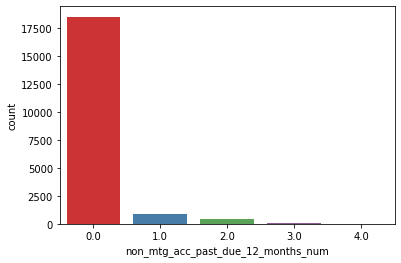

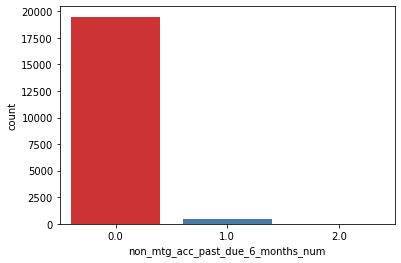

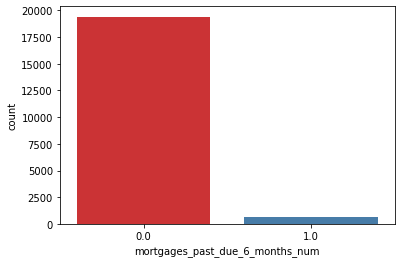

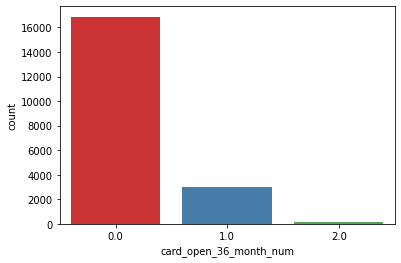

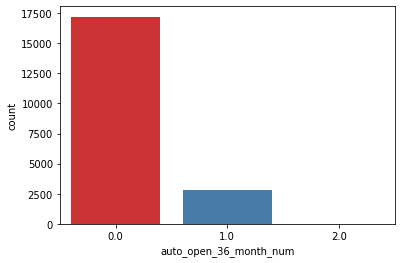

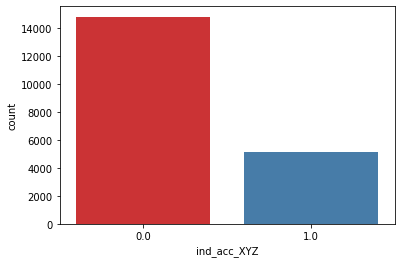

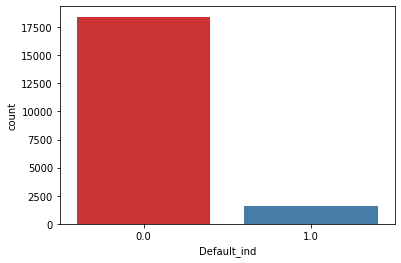

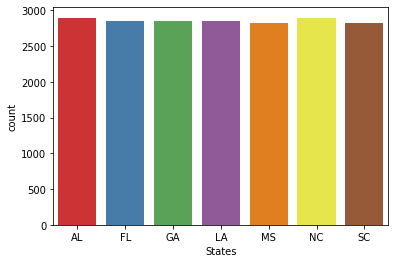

In [10]:
####Part 2: Exploring Data
#numerics only
# Limiting the data
#train_data.dtypes
train_data_numeric = train_data[['tot_credit_debt', 'avg_card_debt',
       'credit_age', 'credit_good_age', 'card_age', 'credit_past_due_amount', 'inq_12_month_num', 'card_inq_24_month_num',
       'uti_card', 'uti_50plus_pct', 'uti_max_credit_line', 'uti_card_50plus_pct','rep_income']]

train_data_numeric = train_data[['tot_credit_debt',
       'credit_age', 'card_age', 'credit_past_due_amount', 'inq_12_month_num',
       'uti_card','rep_income']]

# Visualize the data using seaborn Pairplots
#g = sns.pairplot(train_data_numeric, diag_kws={'bw': 0.2})
#g


#categoricals
train_data_categorical = ['non_mtg_acc_past_due_12_months_num','non_mtg_acc_past_due_6_months_num','mortgages_past_due_6_months_num','card_open_36_month_num','auto_open_36_month_num','ind_acc_XYZ','Default_ind','States']
for f in train_data_categorical:
    plt.figure()
    ax = sns.countplot(x=f, data=train_data, palette="Set1")

In [ ]:
####Part 3: Setting up the x and y train/test

In [10]:
#####Train data
x = new_train_data.iloc[:,[0,1,2,3,7,10,14,17,18,19,20,21,22,23,24,25,26,27,28,29]] #When i turned the objects/category into dummies,new columns were made
x
y = new_train_data.loc[:,'Default_ind'] #make sure your y is a cateogry and not object, don't do dummies for the rresponse variable


#Part 3: Making the xtrain, xtest, etc
xtrain, xtest, ytrain, ytest = ms.train_test_split(x, y, test_size = 0.8, random_state = 10) #test_size and train_size is how big (0-1.0) you want to use the dataset for this
print(xtrain)

       tot_credit_debt  ...  card_open_36_month_num_2.0
10819         0.266875  ...                           0
15490         0.543302  ...                           0
11221         0.548571  ...                           0
13900         0.433731  ...                           0
1264          0.541885  ...                           0
...                ...  ...                         ...
9372          0.441414  ...                           0
7291          0.410480  ...                           0
17728         0.440275  ...                           0
7293          0.402444  ...                           0
17673         0.526777  ...                           0

[4000 rows x 20 columns]


In [11]:
#####Valid data
x_valid_data = new_valid_data.iloc[:,[0,1,2,3,7,10,14,17,18,19,20,21,22,23,24,25,26,27,28,29]] #When i turned the objects/category into dummies,new columns were made
x
y_valid_data = new_valid_data.loc[:,'Default_ind'] #make sure your y is a cateogry and not object, don't do dummies for the rresponse variable


#Part 3: Making the xtrain, xtest, etc
xtrain_valid, xtest_valid, ytrain_valid, ytest_valid = ms.train_test_split(x_valid_data, y_valid_data, test_size = 0.05, random_state = 1) #test_size and train_size is how big (0-1.0) you want to use the dataset for this


In [12]:
#####Test data
x_test_data = new_test_data.iloc[:,[0,1,2,3,7,10,14,17,18,19,20,21,22,23,24,25,26,27,28,29]] #When i turned the objects/category into dummies,new columns were made
x
y_test_data = new_test_data.loc[:,'Default_ind'] #make sure your y is a cateogry and not object, don't do dummies for the rresponse variable


#Part 3: Making the xtrain, xtest, etc
xtrain_test, xtest_test, ytrain_test, ytest_test = ms.train_test_split(x_test_data, y_test_data, test_size = 0.30, random_state = 1) #test_size and train_size is how big (0-1.0) you want to use the dataset for this


In [13]:
####Confusion plot
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True, annot_kws={'size':50})
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
####Part 4: Doing Random Forest without tuning

Training Accuracy is:  1.0
Testing Accuracy is:  0.924


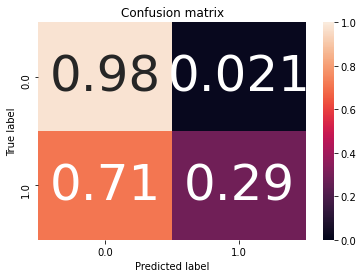

In [14]:
rf = RandomForestClassifier(n_estimators=1000, criterion='entropy')
rf.fit(xtrain, ytrain)
prediction_test = rf.predict(X=xtest_test)

#Checking its accuracy and testing it
# Accuracy on Test
print("Training Accuracy is: ", rf.score(xtrain, ytrain))
# Accuracy on Train
print("Testing Accuracy is: ", rf.score(xtest_test, ytest_test))

rf_fit = rf.fit(xtrain, ytrain)
ypred = rf_fit.predict_proba(xtest_test)[::,1]
metrics.roc_auc_score(ytest_test, ypred) #Auc according to random forest is 0.84

prediction_test = rf_fit.predict(X=xtest_test)

cm = confusion_matrix(ytest_test, prediction_test)
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_norm, classes=rf.classes_)

In [ ]:
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)


# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print ("The True Positive rate / Recall per class is: ",TPR)

# Precision or positive predictive value
PPV = TP/(TP+FP)
print ("The Precision per class is: ",PPV)

# False positive rate or False alarm rate
FPR = FP/(FP+TN)
print ("The False Alarm rate per class is: ",FPR)

# False negative rate or Miss Rate
FNR = FN/(TP+FN)
print ("The Miss Rate rate per class is: ",FNR)

# Classification error
CER = (FP+FN)/(TP+FP+FN+TN)
print ("The Classification error of each class is", CER)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print ("The Accuracy of each class is", ACC)
print("")

#F1 score
F1 = TP/(TP + (0.5*(FP+FN)))

##Total averages :
print ("The average Recall is: ",TPR.sum()/2)
print ("The average Precision is: ",PPV.sum()/2)
print ("The average False Alarm is: ",FPR.sum()/2)
print ("The average Miss Rate rate is: ",FNR.sum()/2)
print ("The average Classification error is", CER.sum()/2)
print ("The average Accuracy is", ACC.sum()/2) #accuracy is 0.93
print ("The average F1 Score is", F1.sum()/2) #its 0.72

The True Positive rate / Recall per class is:  [0.97900072 0.27731092]
The Precision per class is:  [0.94019471 0.53225806]
The False Alarm rate per class is:  [0.72268908 0.02099928]
The Miss Rate rate per class is:  [0.02099928 0.72268908]
The Classification error of each class is [0.07666667 0.07666667]
The Accuracy of each class is [0.92333333 0.92333333]

The average Recall is:  0.6281558242413547
The average Precision is:  0.7362263896989547
The average False Alarm is:  0.37184417575864526
The average Miss Rate rate is:  0.37184417575864526
The average Classification error is 0.07666666666666666
The average Accuracy is 0.9233333333333333
The average F1 Score is 0.6619231379804367


In [ ]:
####Part 5: Doing Random Forest with Hyperparameters

In [15]:
##Hyperparameter Tuning
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1200, num = 3)] 
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [2,10]
# Minimum number of samples required to split a node
min_samples_split = [2, 5,7]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]
#Same as min_samples_leaf,but expressed as a fraction of the total number of weighted instances 
min_weight_fraction_leaf = []
criterion = ['gini', 'entropy']

# Create the param grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion}

print(param_grid)


{'n_estimators': [200, 700, 1200], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [2, 10], 'min_samples_split': [2, 5, 7], 'min_samples_leaf': [1, 2], 'bootstrap': [True, False], 'criterion': ['gini', 'entropy']}


In [16]:
from sklearn.model_selection import GridSearchCV #note: make sure that xtrain and ytrain have the same row
from sklearn.metrics import f1_score, make_scorer #if you want to make your own f1 score

rf_Model = RandomForestClassifier()

f1 = make_scorer(f1_score , average='macro')

rf_Grid = GridSearchCV(estimator = rf_Model, param_grid = param_grid, cv = 5, verbose=2, n_jobs = 4, scoring='f1')
rf_Grid = GridSearchCV(estimator = rf_Model, param_grid = param_grid, cv = 5, verbose=2, n_jobs = 4, scoring=f1)

train_rf = rf_Grid.fit(xtrain_valid, ytrain_valid)

train_rf.best_params_


Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   41.7s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:  8.7min
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed: 17.2min
[Parallel(n_jobs=4)]: Done 1005 tasks      | elapsed: 29.7min
[Parallel(n_jobs=4)]: Done 1450 tasks      | elapsed: 41.8min
[Parallel(n_jobs=4)]: Done 1977 tasks      | elapsed: 58.8min
[Parallel(n_jobs=4)]: Done 2160 out of 2160 | elapsed: 68.6min finished


{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 7,
 'n_estimators': 200}

In [17]:
print(train_rf.best_params_)

{'bootstrap': False, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 200}


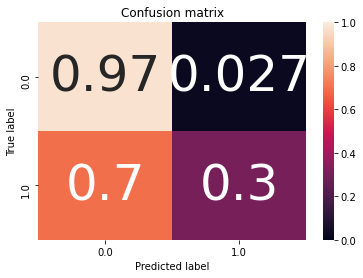

In [18]:
rf = RandomForestClassifier(n_estimators = train_rf.best_params_['n_estimators'], max_features = train_rf.best_params_['max_features'],max_depth = train_rf.best_params_['max_depth'], min_samples_split = train_rf.best_params_['min_samples_split'], min_samples_leaf = train_rf.best_params_['min_samples_leaf'], bootstrap = train_rf.best_params_['bootstrap'], criterion = train_rf.best_params_['criterion'])
rf_fit = rf.fit(xtrain,ytrain) #use this to deploy
ypred = rf_fit.predict_proba(xtest_test)[::,1]

metrics.roc_auc_score(ytest_test, ypred) #AUC is 0.85

prediction_test = rf_fit.predict(X=xtest_test)

cm = confusion_matrix(ytest_test, prediction_test)
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_norm, classes=rf.classes_)


In [11]:
metrics.roc_auc_score(ytest_test, ypred) #AUC is 0.80
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)


# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print ("The True Positive rate / Recall per class is: ",TPR)

# Precision or positive predictive value
PPV = TP/(TP+FP)
print ("The Precision per class is: ",PPV)

# False positive rate or False alarm rate
FPR = FP/(FP+TN)
print ("The False Alarm rate per class is: ",FPR)

# False negative rate or Miss Rate
FNR = FN/(TP+FN)
print ("The Miss Rate rate per class is: ",FNR)

# Classification error
CER = (FP+FN)/(TP+FP+FN+TN)
print ("The Classification error of each class is", CER)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print ("The Accuracy of each class is", ACC)
print("")

#F1 score
F1 = TP/(TP + (0.5*(FP+FN)))

##Total averages :
print ("The average Recall is: ",TPR.sum()/2)
print ("The average Precision is: ",PPV.sum()/2)
print ("The average False Alarm is: ",FPR.sum()/2)
print ("The average Miss Rate rate is: ",FNR.sum()/2)
print ("The average Classification error is", CER.sum()/2)
print ("The average Accuracy is", ACC.sum()/2) #accuracy is 0.93
print ("The average F1 Score is", F1.sum()/2) #its 0.68, better than before
f1_score(ytest_test, prediction_test)

NameError: ignored

In [20]:
print(rf)


RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=7,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


  Created wheel for rfpimp: filename=rfpimp-1.3.7-py3-none-any.whl size=10667 sha256=bfe8008f0b6300254c3c51678f260a1f929914e1cc58eea530805be200f70ea8
  Stored in directory: /root/.cache/pip/wheels/ad/48/d9/21fc62fbeff405425b0d5dd8b0354576cdb62ac97f6b11d1ef
Successfully built rfpimp


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


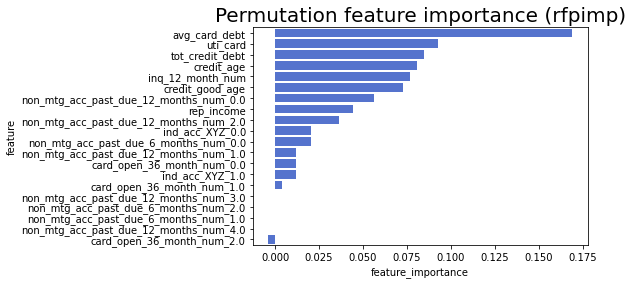

In [25]:
#Final step: shows how each predictor is important
!pip install rfpimp
from sklearn.metrics import r2_score
from rfpimp import permutation_importances

def r2(rf, xtrain, ytrain):
    return r2_score(ytrain, rf.predict(xtrain))

perm_imp_rfpimp = permutation_importances(rf, xtrain, ytrain, r2)
perm_imp_rfpimp.reset_index(drop = False, inplace = True)
perm_imp_rfpimp

# function for creating a feature importance dataframe
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df, title):
    imp_df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', color = 'royalblue') \
       .set_title(title, fontsize = 20)

var_imp_plot(perm_imp_rfpimp, 'Permutation feature importance (rfpimp)') 

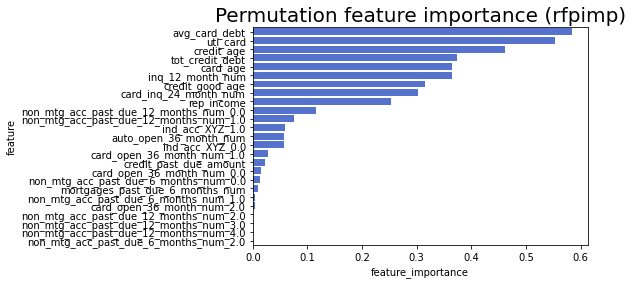

In [29]:
####this is a test to see which predictors is most important
x2 = new_train_data.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,14,17,18,19,20,21,22,23,24,25,26,27,28,29]]
x2
y2 = new_train_data.loc[:,'Default_ind'] #make sure your y is a cateogry and not object, don't do dummies for the rresponse variable

xtrain2, xtest2, ytrain2, ytest2 = ms.train_test_split(x2, y2, test_size = 0.2, random_state = 10)

rf = RandomForestClassifier(n_estimators=1000, criterion='entropy')
rf.fit(xtrain2, ytrain2)

from sklearn.metrics import r2_score
from rfpimp import permutation_importances

def r2(rf, xtrain2, ytrain2):
    return r2_score(ytrain2, rf.predict(xtrain2))

perm_imp_rfpimp = permutation_importances(rf, xtrain2, ytrain2, r2)
perm_imp_rfpimp.reset_index(drop = False, inplace = True)
perm_imp_rfpimp

# function for creating a feature importance dataframe
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df, title):
    imp_df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', color = 'royalblue') \
       .set_title(title, fontsize = 20)

var_imp_plot(perm_imp_rfpimp, 'Permutation feature importance (rfpimp)') 

In [ ]:
########IMPORTANT: When you have time, change the random forest classifier with balancedrandomforestclassifier and put weights to it in order to combat imbalance data